In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import spacy
from spacy.tokens import Token

In [2]:
doc = "In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph in this context is made up of vertices, also called nodes or points, which are connected by edges, also called links or lines. A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically. Graphs are one of the principal objects of study in discrete mathematics."

In [3]:
doc

'In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph in this context is made up of vertices, also called nodes or points, which are connected by edges, also called links or lines. A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically. Graphs are one of the principal objects of study in discrete mathematics.'

# 1. From graph-representation.ipynb

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
def preprocess_document(document, stopwords=stopwords, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()
    
    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')
    
    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    
    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        words = [w for w in words if w not in stopwords]
        document.append(words)
        
    return document

In [6]:
def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

In [7]:
def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            pair = [sent[i], sent[i+1]]
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

In [8]:
def plot_graph(G, title=None, highlight_nodes=[]):
    # set figure size
    plt.figure(figsize=(10,10))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    # node colors
    colors = ['red' if node in highlight_nodes else 'green' for node in G.nodes()]
    
    # draw nodes and edges
    nx.draw(G, pos=pos, node_color=colors, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

In [9]:
def build_digraph(document):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    # get graph nodes
    nodes = get_entities(pdoc)
    # get graph edges
    edges = get_relations(pdoc)
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

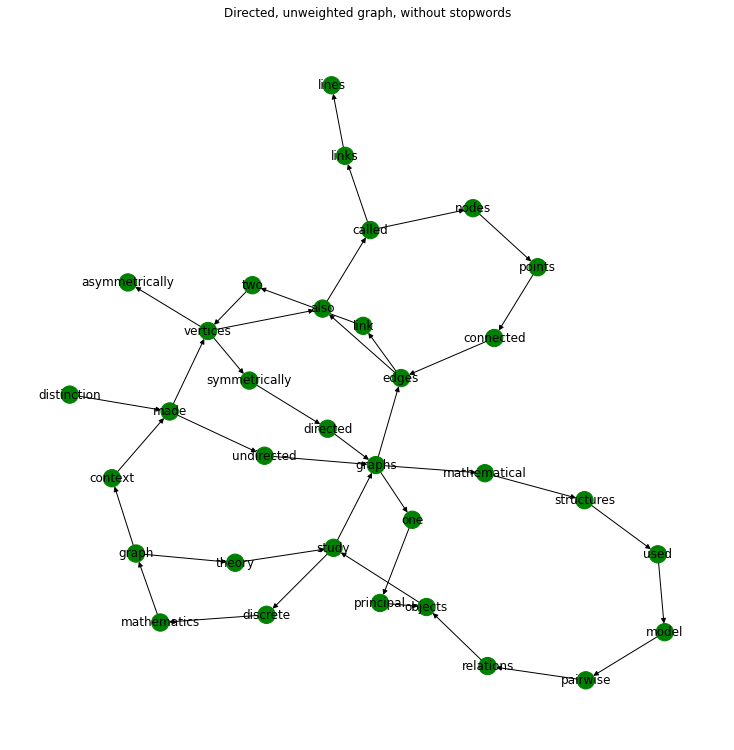

In [10]:
G = build_digraph(doc)
plot_graph(G, title='Directed, unweighted graph, without stopwords')

# 2. Graph centrality

In [11]:
# can be any type of centrality
node_scores = nx.betweenness_centrality(G)

In [12]:
# from highest to lowest (hence the negative sign)
sorted_node_scores = dict(sorted(node_scores.items(), key=lambda item: -item[1]))

In [13]:
sorted_node_scores

{'graphs': 0.561491935483871,
 'study': 0.4254032258064516,
 'objects': 0.34677419354838707,
 'edges': 0.34576612903225806,
 'vertices': 0.28931451612903225,
 'two': 0.22076612903225806,
 'link': 0.21875,
 'directed': 0.19959677419354838,
 'symmetrically': 0.1975806451612903,
 'principal': 0.1723790322580645,
 'one': 0.17036290322580644,
 'called': 0.16532258064516128,
 'also': 0.16330645161290322,
 'graph': 0.1592741935483871,
 'mathematics': 0.15725806451612903,
 'discrete': 0.15524193548387097,
 'relations': 0.1411290322580645,
 'pairwise': 0.13911290322580644,
 'model': 0.13709677419354838,
 'used': 0.1350806451612903,
 'structures': 0.13306451612903225,
 'mathematical': 0.1310483870967742,
 'made': 0.12096774193548387,
 'connected': 0.11088709677419355,
 'points': 0.10887096774193548,
 'nodes': 0.10685483870967742,
 'context': 0.08669354838709677,
 'undirected': 0.056451612903225805,
 'theory': 0.04536290322580645,
 'links': 0.03024193548387097,
 'lines': 0.0,
 'distinction': 0.0,

# 3. Candidate Keywords

In [14]:
# candidate KW = highest scoring nodes (1/3 of all nodes)
sorted_nodes = list(sorted_node_scores.keys())
candidate_kw = sorted_nodes[:int(len(sorted_nodes)/3)]

In [15]:
candidate_kw

['graphs',
 'study',
 'objects',
 'edges',
 'vertices',
 'two',
 'link',
 'directed',
 'symmetrically',
 'principal',
 'one']

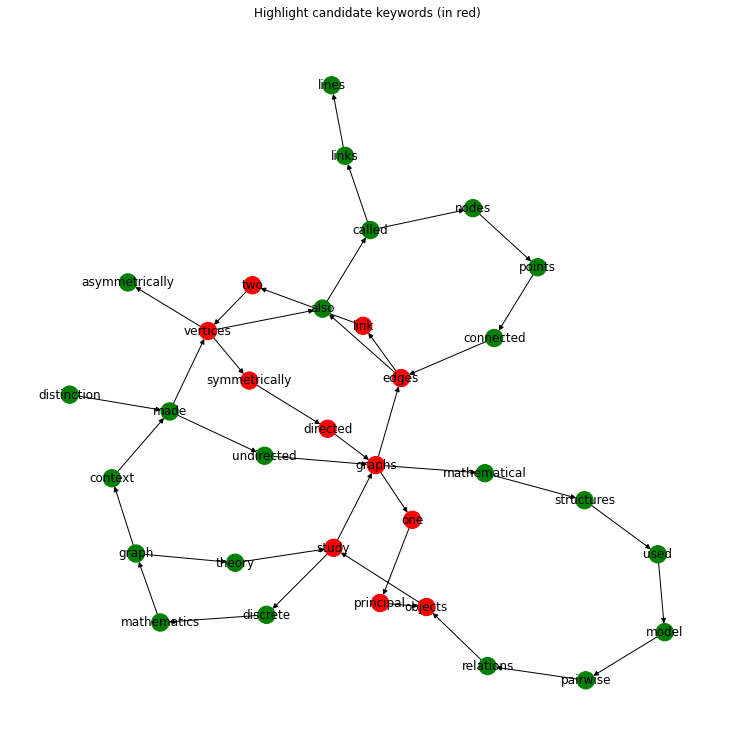

In [16]:
plot_graph(G, title='Highlight candidate keywords (in red)', highlight_nodes=candidate_kw)

# 4. Extracting keyphrases (with spacy)

In [17]:
def transform_uni_to_ngram(unigram_keywords, text):
        """
        Candidate unigrams that form ngrams in the text
        are merged and now form a single candidate keyphrase.
        """
        nlp = spacy.load("en_core_web_sm")
        
        # function that tells if spacy token is keyword or not
        ckw_getter = lambda token: token.text.lower() in unigram_keywords
        # set that function as token extension (as attribute with ._)
        Token.set_extension("is_ckw", getter=ckw_getter, force=True)
        
        # variable to store resulting keyphrases
        res = []
        # split original text in sentences
        sentences = nltk.sent_tokenize(text)
        for sent in sentences:
            # start keyphrase as empty string
            merged_tokens = ''
            # process sentence with spacy model defined beforehand
            sent = nlp(sent)
            for token in sent:
                # if token is candidate KW (according to func defined before)
                if token._.is_ckw:
                    # add it to keyphrase
                    merged_tokens += token.text.lower() + ' '
                # means that sequence of tokens in text that are candidate KW ends
                else:
                    # check if keyphrase not empty and already not in list of results
                    if merged_tokens != '' and merged_tokens.strip() not in res:
                        # only add keyphrases for now, no unigrams
                        if len(merged_tokens.strip().split(' ')) != 1:
                            res.append(merged_tokens.strip())
                        # set keyphrase as empty string again
                        merged_tokens = ''
                        
                        
        for uni in unigram_keywords:
            # only add unigram KW to results list if not there already
            if uni not in res:
                add_uni = True
                for other in res:
                    # only add unigram KW to results list if not used in keyphrase somewhere
                    if uni in other:
                        add_uni = False
                if add_uni:
                    res.append(uni)   
        return res

In [18]:
transform_uni_to_ngram(candidate_kw, doc)

['edges link two vertices symmetrically',
 'directed graphs',
 'edges link two vertices',
 'principal objects',
 'study',
 'one']